# Loading Hyperbolic Orbits into REBOUND

Imagine we have a table of orbital elements for comets (kindly provided by Toni Engelhardt).

In [1]:
from io import StringIO
import numpy as np
import rebound
c = StringIO("""
# tracklet_id  e          q[AU]      i[deg]      Omega[deg]    argperi[deg]  t_peri[MJD, days]  epoch_of_elements[MJD, days]  epoch_of_observation[MJD, days]
168026         12.181214  15.346358  136.782470  37.581438     268.412314    54776.806093       53371.000000                  55516.41727
21170          2.662235   2.013923   140.646538  23.029490     46.292039     54336.126288       53371.000000                  53673.44043   
189298         15.503013  11.550314  20.042232   203.240743    150.855761    55761.641176       53371.000000                  55718.447145 
72278          34.638392  24.742323  157.984412  126.431540    178.612758    54382.158401       53371.000000                  54347.240445
109766         8.832472   9.900228   144.857801  243.102255    271.345342    55627.501618       53371.000000                  54748.37722
""")
comets = np.loadtxt(c) # load the table into a numpy array

We now want to add these to simulation(s).  The first thing to do is set the units, which have to be consistent throughout.  Here we have a table in AU and days, so we'll use the gaussian gravitational constant (AU, days, solar masses).  

In [2]:
sim = rebound.Simulation()
k = 0.01720209895 # Gaussian constant
sim.G = k**2

We would then add the giant planets to the simulation.  You could for example query JPL HORIZONS for the states of the planets at each comet's corresponding epoch of observation (see [Horizons.ipynb](Horizons.ipynb)).  Here we set up toy masses and orbits for Jupiter & Saturn:

In [3]:
sim.add(m=1.) # Sun
sim.add(m=1.e-3, a=5.) # Jupiter
sim.add(m=3.e-4, a=10.) # Saturn

Let's write a function that takes a comet from the table and returns an orbit:

In [4]:
def getOrbit(comet_elem):
    o = rebound.Orbit()
    o.e = comet_elem[1]
    o.a = comet_elem[2]/(1.-o.e) # q = a(1-e)
    o.inc = comet_elem[3]*np.pi/180. # have to convert to radians
    o.Omega = comet_elem[4]*np.pi/180.
    o.omega = comet_elem[5]*np.pi/180.
    o.T = comet_elem[6] # time of pericenter passage
    return o

We can now set up the first comet.  We begin by setting the simulation time to the epoch at which the elements are valid (epoch of elements in the table):

In [5]:
comet_elem = comets[0]
sim.t = comet_elem[-2] # second-to-last column is the epoch of elements
o = getOrbit(comet_elem)
sim.add(a=o.a, e=o.e, inc=o.inc, Omega=o.Omega, omega=o.omega, T=o.T)

By default, REBOUND adds and outputs particles in jacobi orbital elements.  Typically orbital elements for comets are heliocentric.  Mixing the two will give you relative errors in elements, positions etc. of order the mass ratio of Jupiter to the Sun ($\sim 0.001$).  If that matters to you, you should additionally pass `primary=sim.particles[0]` in the `add` call above, and you'd output with:

In [6]:
comet = sim.particles[3]
print(comet.calculate_orbit(primary=sim.particles[0]))

<rebound.Orbit instance, a=-1.3693776114850575 e=12.209650155567674 inc=2.3875588019141802 Omega=0.6563653854368061 omega=-1.5986637683201947 f=-0.9911585901103712>


You'll notice that, as expected, these elements differ from the ones in the table above by $\sim 0.001$ because we added in Jacobi, and outputted heliocentric.  If you're consistent, they'll be the same.  We can quickly plot what the system looks like:

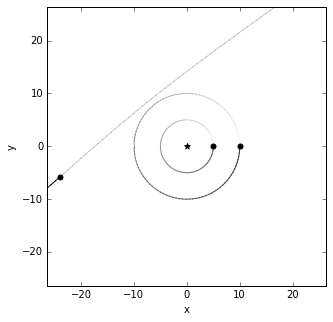

In [7]:
%matplotlib inline
fig = rebound.OrbitPlot(sim, trails=True)

Now we just integrate until whatever final time we’re interested in.  Here it's the epoch at which we observe the comet, which is the last column in our table:

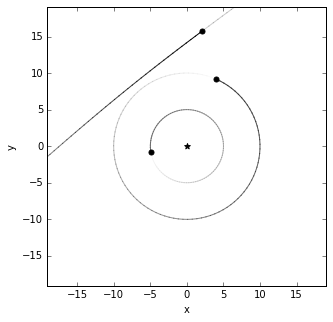

In [8]:
tfinal = comet_elem[-1]
sim.integrate(tfinal)
fig = rebound.OrbitPlot(sim, trails=True)

In [9]:
print(comet.orbit)

<rebound.Orbit instance, a=-1.3725087553204571 e=12.18118486515534 inc=2.3873044687312324 Omega=0.6559356396652458 omega=-1.598501496619612 f=0.6622565449902121>


The osculating elements change slightly because of the presence of the giant planets.  For fun, let's add them all to a simulation:

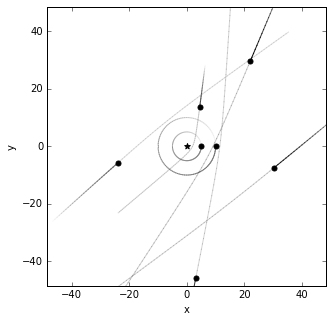

In [10]:
sim = rebound.Simulation()
k = 0.01720209895 # Gaussian constant
sim.G = k**2
sim.add(m=1.) # Sun
sim.add(m=1.e-3, a=5.) # Jupiter
sim.add(m=3.e-4, a=10.) # Saturn
for comet_elem in comets:
    sim.t = comet_elem[-2]
    o = getOrbit(comet_elem)
    sim.add(a=o.a, e=o.e, inc=o.inc, Omega=o.Omega, omega=o.omega, T=o.T)
fig = rebound.OrbitPlot(sim, trails=True)